In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
from scipy.optimize import curve_fit

In [2]:
def generate_U(omega,phi,dt):
    return np.array([[np.cos(omega*dt),-1j*np.exp(1j*phi)*np.sin(omega*dt)],[-1j*np.exp(-1j*phi)*np.sin(omega*dt),np.cos(omega*dt)]])

In [3]:
# correlation function for phi
def func_correlation(t,tau):
    return np.exp(-t/tau)

In [4]:
def func_correlation(t,w0,tau):
    return np.cos(t*w0)*np.exp(-t/tau)

In [5]:
T = 3
dt = 0.1
t_list = np.arange(0,T,dt)
dim = len(t_list)
tau = 1.0
cov = np.zeros([dim,dim])
for i in range(dim):
    for j in range(dim):
        cov[i,j] = func_correlation(abs(i-j)*dt,tau)

time_trace = []
realization = 100
for rl in range(realization):
    time_trace += [np.random.multivariate_normal([0]*dim,cov)]
time_trace = np.array(time_trace).transpose()
#plt.plot(t_list,time_trace)

plt.plot(t_list,np.var(time_trace,axis=1),color='black')



plt.plot(t_list,time_trace.dot(time_trace[0])/time_trace[0].dot(time_trace[0]),color='red')

#plt.show()

TypeError: func_correlation() missing 1 required positional argument: 'tau'

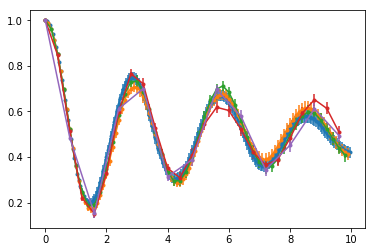

In [6]:
Omega = 1.0
w0 = Omega
tau = 10.


T = 10

realization = 100


for dt in [0.05,0.1,0.2,0.4,0.8]:
    t_list = np.arange(0,T,dt)
    dim = len(t_list)

    cov = np.zeros([dim,dim])
    for i in range(dim):
        for j in range(dim):
            cov[i,j] = func_correlation(abs(i-j)*dt,w0,tau)

    time_trace = np.zeros_like(t_list)        
    time_trace_err = np.zeros_like(t_list)        
    for rl in range(realization):
        phi_list = np.random.multivariate_normal([0]*dim,cov)

        state = np.array([1.,0.])

        for i_phi,phi in enumerate(phi_list):
            time_trace[i_phi] += abs(state[0])**2
            time_trace_err[i_phi] += abs(state[0])**4
            state = generate_U(Omega,phi,dt).dot(state)
    time_trace_err -= time_trace**2/realization
    time_trace_err[np.where(time_trace_err<=0)[0]] = 0
    time_trace_err = time_trace_err**0.5/realization
    #print time_trace_err
    time_trace /= realization

    plt.errorbar(t_list,time_trace,yerr=time_trace_err,ls='-',marker='.')

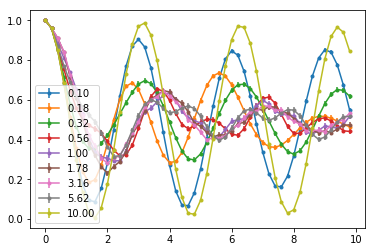

In [92]:
Omega = 1.0
#w0 = Omega
tau = 10.*2*np.pi


T = 10

realization = 500

dt = 0.2

for w0 in np.logspace(-1.,1.,9)*Omega*(2*np.pi):
    t_list = np.arange(0,T,dt)
    dim = len(t_list)

    cov = np.zeros([dim,dim])
    for i in range(dim):
        for j in range(dim):
            cov[i,j] = func_correlation(abs(i-j)*dt,w0,tau)

    time_trace = np.zeros_like(t_list)        
    time_trace_err = np.zeros_like(t_list)        
    for rl in range(realization):
        phi_list = np.random.multivariate_normal([0]*dim,cov)

        state = np.array([1.,0.])

        for i_phi,phi in enumerate(phi_list):
            time_trace[i_phi] += abs(state[0])**2
            time_trace_err[i_phi] += abs(state[0])**4
            state = generate_U(Omega,phi,dt).dot(state)
    time_trace_err -= time_trace**2/realization
    time_trace_err[np.where(time_trace_err<=0)[0]] = 0
    time_trace_err = time_trace_err**0.5/realization
    #print time_trace_err
    time_trace /= realization

    plt.errorbar(t_list,time_trace,yerr=time_trace_err,ls='-',marker='.',label='%.2f'%(w0/(2*np.pi)))
plt.legend()

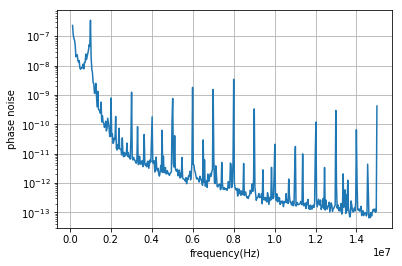

In [8]:
data_exp = np.array(np.loadtxt('./PHASE1_Node_14 (1).csv',delimiter=',',skiprows=58,usecols=[0,1]))
f = data_exp[:,0]
N = len(f)

P_dbm = data_exp[:,1] #AC noise in dbm
P_w = [10**((x-30)/10) for x in P_dbm] #AC noise in W
Err_u = [2*50*x for x in P_w] # AC noise(amplitude square)
Err_f = [x*(1000/0.044)**2 for x in Err_u] #laser frequency noise in Hz^2
Err_phi = [Err_f[i]/f[i]**2 for i in range(N)] #laser phase noise 
plt.yscale("log")
plt.plot(f,Err_phi)
plt.ylabel("phase noise")
plt.xlabel("frequency(Hz)")
plt.grid()
N = len(f)
t = np.arange(0,1/(f[1]-f[0])+1e-10,1/(f[-1]-f[0]))
Err_t = np.zeros(N)#correlator 
for j in range(N):
    Err_t[j] = sum([Err_phi[i] * np.cos(2*np.pi*f[i] * t[j]) for i in range(N)])*(f[1]-f[0])
    # Err_t[j] = sum([Err_phi[i] * np.cos(2*np.pi*f[i] * t[j]) for i in range(N)])*10000


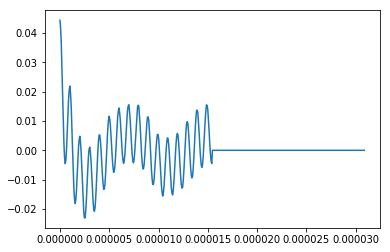

In [9]:
Err_t[int(len(Err_t)/2):] = 0
t_spacing=t[1]-t[0]
plt.plot(t,Err_t)

C:\Users\wangy\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


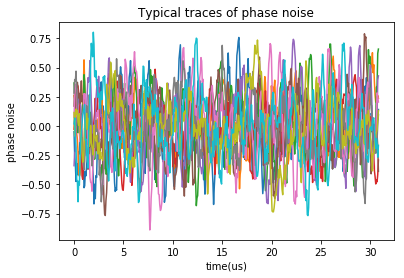

In [19]:
Omega = 1.25e6
T = t[-1]

realization = 10
t_list = np.arange(0,T,t_spacing)
dim = len(t_list)
cov = np.zeros([dim,dim])
for i in range(dim):
    for j in range(dim):
        cov[i,j] = Err_t[abs(i-j)]*2*np.pi/5

            #cov[i,j] = func_correlation(abs(i-j)*dt,w0,tau)

time_trace = np.zeros_like(t_list)        
time_trace_err = np.zeros_like(t_list)        
for rl in range(realization):
    phi_list = np.random.multivariate_normal([0]*dim,cov)
    plt.plot(t_list*1e6,phi_list)
    state = np.array([1.,0.])
    for i_phi,phi in enumerate(phi_list):
        time_trace[i_phi] += abs(state[0])**2
        time_trace_err[i_phi] += abs(state[0])**4
        state = generate_U(Omega,phi,dt).dot(state)
    np.savetxt(str(rl)+'.txt',np.transpose([t_list*1e6,phi_list]))
time_trace_err -= time_trace**2/realization
time_trace_err[np.where(time_trace_err<=0)[0]] = 0
time_trace_err = time_trace_err**0.5/realization

time_trace_cut = time_trace[:int(len(Err_t)/2)]
yerr = time_trace_err[:int(len(Err_t)/2)]
t_list_cut = t_list[:int(len(Err_t)/2)]

    #print time_trace_err
time_trace /= realization
plt.xlabel("time(us)")
plt.ylabel("phase noise")
plt.title("Typical traces of phase noise")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

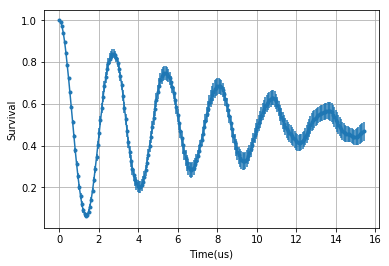

In [236]:
plt.errorbar(1e6*t_list_cut,time_trace_cut,yerr,ls='-',marker='.')
plt.xlabel("Time(us)")
plt.ylabel("Survival")
plt.grid()
plt.show

[1.14785558e-03 3.77437657e-05 5.24669972e-01 1.93721731e-04]


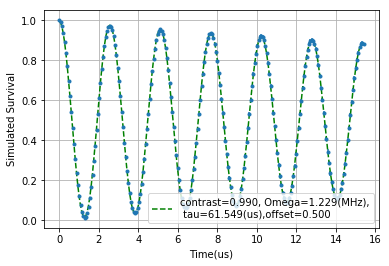

In [283]:
def fit_func(x, a, b, c, d):
    return a * np.cos(2*b*x) * np.exp(-x/c)/2+d 

popt,pcov = curve_fit(fit_func, 1e6*t_list_cut, time_trace_cut,bounds=([0.4,0,0,0],[1,3,100,1]))
#print(params[0])
plt.plot(1e6*t_list_cut, fit_func(1e6*t_list_cut, *popt), 'g--',
         label='contrast=%5.3f, Omega=%5.3f(MHz),\n tau=%5.3f(us),offset=%5.3f' % tuple(popt))
plt.legend(loc="lower right")
plt.errorbar(1e6*t_list_cut,time_trace_cut,yerr,marker='.',linestyle='none')
plt.xlabel("Time(us)")
plt.ylabel("Simulated Survival")
plt.grid()
plt.show
print(np.sqrt(np.diag(pcov)))

In [199]:
f[1]-f[0]

32391.304400000023

In [166]:
np.shape(t_list)

(459,)